In [1]:

import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import pandas as pd

In [3]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [4]:
test_path= './test'

In [5]:
test_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range= 0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                 validation_split = 0.1)

#test_datagen = ImageDataGenerator(rescale=1.0/255)

#Read our images to the data augmentations
#Generates batches of augmented data
train = test_datagen.flow_from_directory(test_path,
                                          color_mode = 'grayscale',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          class_mode = 'categorical',
                                        subset='training')

test = test_datagen.flow_from_directory(test_path,
                                          color_mode = 'grayscale',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          class_mode = 'categorical',
                                        subset='validation')


Found 32302 images belonging to 7 classes.
Found 3585 images belonging to 7 classes.


In [6]:
train

In [7]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train.classes), 
                                                  y=train.classes)
class_weights = dict(zip(np.unique(train.classes),class_weights))

filepath = 'saved_model/wuhuCustomCopy' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=1, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=1,restore_best_weights=True)]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
print(class_weights)


{0: 1.0351214510030122, 1: 9.360185453491741, 2: 1.0012088150512972, 3: 0.5703338806787083, 4: 0.827132358589609, 5: 0.8436145207626012, 6: 1.281113667010391}


In [10]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),strides=(1,1),padding="valid",activation="relu",input_shape=(48,48,1)))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(256,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(layers.Dense(7,activation="softmax"))

#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam(lr=0.01)
metrics = ["accuracy"]
#model.compile(optimizer = optim, loss=loss,metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

C:\Users\Administrator\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
history = model.fit(train,epochs=10,validation_data=test,verbose=1,callbacks=callbacks)


Epoch 1/10
505/505 [==============================] - ETA: 0s - loss: 1.7918 - accuracy: 0.3172
Epoch 1: val_accuracy improved from -inf to 0.31688, saving model to saved_model\wuhuCustomCopy
INFO:tensorflow:Assets written to: saved_model\wuhuCustomCopy\assets
505/505 [==============================] - 51s 100ms/step - loss: 1.7918 - accuracy: 0.3172 - val_loss: 1.7048 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 2/10
505/505 [==============================] - ETA: 0s - loss: 1.4935 - accuracy: 0.4267
Epoch 2: val_accuracy improved from 0.31688 to 0.44435, saving model to saved_model\wuhuCustomCopy
INFO:tensorflow:Assets written to: saved_model\wuhuCustomCopy\assets
505/505 [==============================] - 42s 83ms/step - loss: 1.4935 - accuracy: 0.4267 - val_loss: 1.4318 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/10
505/505 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.4701
Epoch 3: val_accuracy improved from 0.44435 to 0.47001, saving model to saved_model\wu

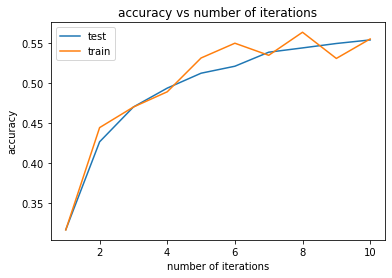

In [14]:
test_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

fig, ax = plt.subplots()
ax.set_xlabel('number of iterations')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs number of iterations')
ax.plot(range(1,len(train_accuracy)+1), train_accuracy,  label="test")
ax.plot(range(1,len(train_accuracy)+1), test_accuracy,  label="train")
ax.legend()
plt.show()

In [15]:
## from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train.classes), 
                                                  y=train.classes)
class_weights = dict(zip(np.unique(train.classes),class_weights))

filepath = 'saved_model/my_model_4' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=50, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=1,restore_best_weights=True)]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.fit(train,epochs=1500,validation_data=test,verbose=1,callbacks=callbacks)

Epoch 1/1500
505/505 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.6752
Epoch 1: val_accuracy improved from -inf to 0.65411, saving model to saved_model\my_model_4
INFO:tensorflow:Assets written to: saved_model\my_model_4\assets
505/505 [==============================] - 37s 71ms/step - loss: 0.8683 - accuracy: 0.6752 - val_loss: 0.9618 - val_accuracy: 0.6541 - lr: 1.0000e-04
Epoch 2/1500
505/505 [==============================] - ETA: 0s - loss: 0.8651 - accuracy: 0.6752
Epoch 2: val_accuracy did not improve from 0.65411
505/505 [==============================] - 35s 70ms/step - loss: 0.8651 - accuracy: 0.6752 - val_loss: 0.9680 - val_accuracy: 0.6513 - lr: 1.0000e-04
Epoch 3/1500
505/505 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.6735
Epoch 3: val_accuracy did not improve from 0.65411
505/505 [==============================] - 36s 71ms/step - loss: 0.8719 - accuracy: 0.6735 - val_loss: 0.9810 - val_accuracy: 0.6399 - lr: 1.0000e-

Epoch 28/1500
505/505 [==============================] - ETA: 0s - loss: 0.8581 - accuracy: 0.6783
Epoch 28: val_accuracy did not improve from 0.65439
505/505 [==============================] - 33s 66ms/step - loss: 0.8581 - accuracy: 0.6783 - val_loss: 0.9739 - val_accuracy: 0.6474 - lr: 1.0000e-04
Epoch 29/1500
505/505 [==============================] - ETA: 0s - loss: 0.8560 - accuracy: 0.6787
Epoch 29: val_accuracy did not improve from 0.65439
505/505 [==============================] - 33s 66ms/step - loss: 0.8560 - accuracy: 0.6787 - val_loss: 0.9649 - val_accuracy: 0.6516 - lr: 1.0000e-04
Epoch 30/1500
505/505 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6759
Epoch 30: val_accuracy improved from 0.65439 to 0.65718, saving model to saved_model\my_model_4
INFO:tensorflow:Assets written to: saved_model\my_model_4\assets
505/505 [==============================] - 35s 69ms/step - loss: 0.8599 - accuracy: 0.6759 - val_loss: 0.9545 - val_accuracy: 0.6572 - lr:

505/505 [==============================] - 34s 67ms/step - loss: 0.8502 - accuracy: 0.6827 - val_loss: 0.9890 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 55/1500
505/505 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.6835
Epoch 55: val_accuracy did not improve from 0.65858
505/505 [==============================] - 33s 66ms/step - loss: 0.8474 - accuracy: 0.6835 - val_loss: 0.9732 - val_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 56/1500
505/505 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.6829
Epoch 56: val_accuracy did not improve from 0.65858
505/505 [==============================] - 33s 66ms/step - loss: 0.8472 - accuracy: 0.6829 - val_loss: 0.9690 - val_accuracy: 0.6402 - lr: 1.0000e-04
Epoch 57/1500
505/505 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.6824
Epoch 57: val_accuracy did not improve from 0.65858
505/505 [==============================] - 34s 67ms/step - loss: 0.8454 - accuracy: 0.6824 - val_

INFO:tensorflow:Assets written to: saved_model\my_model_4\assets
505/505 [==============================] - 35s 69ms/step - loss: 0.8388 - accuracy: 0.6860 - val_loss: 0.9570 - val_accuracy: 0.6591 - lr: 1.0000e-04
Epoch 82/1500
505/505 [==============================] - ETA: 0s - loss: 0.8370 - accuracy: 0.6874
Epoch 82: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 66ms/step - loss: 0.8370 - accuracy: 0.6874 - val_loss: 0.9616 - val_accuracy: 0.6544 - lr: 1.0000e-04
Epoch 83/1500
505/505 [==============================] - ETA: 0s - loss: 0.8340 - accuracy: 0.6880
Epoch 83: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8340 - accuracy: 0.6880 - val_loss: 0.9776 - val_accuracy: 0.6497 - lr: 1.0000e-04
Epoch 84/1500
505/505 [==============================] - ETA: 0s - loss: 0.8369 - accuracy: 0.6863
Epoch 84: val_accuracy did not improve from 0.65914
505/505 [=======================

505/505 [==============================] - 34s 68ms/step - loss: 0.8341 - accuracy: 0.6906 - val_loss: 0.9873 - val_accuracy: 0.6471 - lr: 1.0000e-04
Epoch 109/1500
505/505 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.6914
Epoch 109: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8231 - accuracy: 0.6914 - val_loss: 0.9684 - val_accuracy: 0.6410 - lr: 1.0000e-04
Epoch 110/1500
505/505 [==============================] - ETA: 0s - loss: 0.8277 - accuracy: 0.6913
Epoch 110: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8277 - accuracy: 0.6913 - val_loss: 0.9706 - val_accuracy: 0.6550 - lr: 1.0000e-04
Epoch 111/1500
505/505 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.6900
Epoch 111: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8296 - accuracy: 0.6900 

Epoch 136/1500
505/505 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.6930
Epoch 136: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8186 - accuracy: 0.6930 - val_loss: 0.9611 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 137/1500
505/505 [==============================] - ETA: 0s - loss: 0.8178 - accuracy: 0.6927
Epoch 137: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 67ms/step - loss: 0.8178 - accuracy: 0.6927 - val_loss: 0.9759 - val_accuracy: 0.6550 - lr: 1.0000e-04
Epoch 138/1500
505/505 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.6890
Epoch 138: val_accuracy did not improve from 0.65914
505/505 [==============================] - 34s 68ms/step - loss: 0.8258 - accuracy: 0.6890 - val_loss: 0.9704 - val_accuracy: 0.6466 - lr: 1.0000e-04
Epoch 139/1500
505/505 [==============================] - ETA: 0s - loss: 0.8137 - accuracy

Epoch 163/1500
505/505 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.6960
Epoch 163: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 65ms/step - loss: 0.8142 - accuracy: 0.6960 - val_loss: 0.9775 - val_accuracy: 0.6449 - lr: 1.0000e-04
Epoch 164/1500
505/505 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.6971
Epoch 164: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 65ms/step - loss: 0.8138 - accuracy: 0.6971 - val_loss: 0.9643 - val_accuracy: 0.6614 - lr: 1.0000e-04
Epoch 165/1500
505/505 [==============================] - ETA: 0s - loss: 0.8153 - accuracy: 0.6965
Epoch 165: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 65ms/step - loss: 0.8153 - accuracy: 0.6965 - val_loss: 0.9639 - val_accuracy: 0.6541 - lr: 1.0000e-04
Epoch 166/1500
505/505 [==============================] - ETA: 0s - loss: 0.8175 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.8084 - accuracy: 0.6958
Epoch 190: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.8084 - accuracy: 0.6958 - val_loss: 0.9783 - val_accuracy: 0.6463 - lr: 1.0000e-04
Epoch 191/1500
505/505 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.6987
Epoch 191: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.8091 - accuracy: 0.6987 - val_loss: 0.9784 - val_accuracy: 0.6527 - lr: 1.0000e-04
Epoch 192/1500
505/505 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.6972
Epoch 192: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.8077 - accuracy: 0.6972 - val_loss: 0.9740 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 193/1500
505/505 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.7014
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7916 - accuracy: 0.7053
Epoch 244: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.7916 - accuracy: 0.7053 - val_loss: 0.9681 - val_accuracy: 0.6505 - lr: 1.0000e-04
Epoch 245/1500
505/505 [==============================] - ETA: 0s - loss: 0.7972 - accuracy: 0.7034
Epoch 245: val_accuracy did not improve from 0.66304
505/505 [==============================] - 34s 67ms/step - loss: 0.7972 - accuracy: 0.7034 - val_loss: 0.9805 - val_accuracy: 0.6566 - lr: 1.0000e-04
Epoch 246/1500
505/505 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.7050
Epoch 246: val_accuracy did not improve from 0.66304
505/505 [==============================] - 36s 71ms/step - loss: 0.7973 - accuracy: 0.7050 - val_loss: 0.9786 - val_accuracy: 0.6480 - lr: 1.0000e-04
Epoch 247/1500
505/505 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.7018
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7840 - accuracy: 0.7059
Epoch 298: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.7840 - accuracy: 0.7059 - val_loss: 0.9838 - val_accuracy: 0.6491 - lr: 1.0000e-04
Epoch 299/1500
505/505 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.7048
Epoch 299: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.7848 - accuracy: 0.7048 - val_loss: 0.9564 - val_accuracy: 0.6611 - lr: 1.0000e-04
Epoch 300/1500
505/505 [==============================] - ETA: 0s - loss: 0.7841 - accuracy: 0.7078
Epoch 300: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.7841 - accuracy: 0.7078 - val_loss: 0.9841 - val_accuracy: 0.6522 - lr: 1.0000e-04
Epoch 301/1500
505/505 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7058
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.7118
Epoch 352: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 65ms/step - loss: 0.7783 - accuracy: 0.7118 - val_loss: 0.9750 - val_accuracy: 0.6499 - lr: 1.0000e-04
Epoch 353/1500
505/505 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.7099
Epoch 353: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 65ms/step - loss: 0.7803 - accuracy: 0.7099 - val_loss: 0.9898 - val_accuracy: 0.6510 - lr: 1.0000e-04
Epoch 354/1500
505/505 [==============================] - ETA: 0s - loss: 0.7785 - accuracy: 0.7087
Epoch 354: val_accuracy did not improve from 0.66304
505/505 [==============================] - 33s 66ms/step - loss: 0.7785 - accuracy: 0.7087 - val_loss: 0.9809 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 355/1500
505/505 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.7053
Epoch 

Epoch 379/1500
505/505 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.7114
Epoch 379: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7745 - accuracy: 0.7114 - val_loss: 0.9765 - val_accuracy: 0.6502 - lr: 1.0000e-04
Epoch 380/1500
505/505 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.7101
Epoch 380: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7741 - accuracy: 0.7101 - val_loss: 0.9681 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 381/1500
505/505 [==============================] - ETA: 0s - loss: 0.7756 - accuracy: 0.7111
Epoch 381: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7756 - accuracy: 0.7111 - val_loss: 0.9885 - val_accuracy: 0.6524 - lr: 1.0000e-04
Epoch 382/1500
505/505 [==============================] - ETA: 0s - loss: 0.7793 - accuracy

Epoch 406/1500
505/505 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.7154
Epoch 406: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7635 - accuracy: 0.7154 - val_loss: 0.9710 - val_accuracy: 0.6516 - lr: 8.0000e-05
Epoch 407/1500
505/505 [==============================] - ETA: 0s - loss: 0.7769 - accuracy: 0.7101
Epoch 407: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7769 - accuracy: 0.7101 - val_loss: 0.9839 - val_accuracy: 0.6469 - lr: 8.0000e-05
Epoch 408/1500
505/505 [==============================] - ETA: 0s - loss: 0.7713 - accuracy: 0.7114
Epoch 408: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7713 - accuracy: 0.7114 - val_loss: 0.9884 - val_accuracy: 0.6499 - lr: 8.0000e-05
Epoch 409/1500
505/505 [==============================] - ETA: 0s - loss: 0.7688 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.7154
Epoch 433: val_accuracy did not improve from 0.66388
505/505 [==============================] - 33s 66ms/step - loss: 0.7638 - accuracy: 0.7154 - val_loss: 0.9944 - val_accuracy: 0.6402 - lr: 8.0000e-05
Epoch 434/1500
505/505 [==============================] - ETA: 0s - loss: 0.7686 - accuracy: 0.7121
Epoch 434: val_accuracy did not improve from 0.66388
505/505 [==============================] - 34s 67ms/step - loss: 0.7686 - accuracy: 0.7121 - val_loss: 0.9810 - val_accuracy: 0.6530 - lr: 8.0000e-05
Epoch 435/1500
505/505 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.7149
Epoch 435: val_accuracy did not improve from 0.66388
505/505 [==============================] - 34s 67ms/step - loss: 0.7629 - accuracy: 0.7149 - val_loss: 0.9666 - val_accuracy: 0.6633 - lr: 8.0000e-05
Epoch 436/1500
505/505 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.7152
Epoch 

Epoch 460/1500
505/505 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.7156
Epoch 460: val_accuracy did not improve from 0.66639
505/505 [==============================] - 35s 69ms/step - loss: 0.7630 - accuracy: 0.7156 - val_loss: 0.9882 - val_accuracy: 0.6536 - lr: 8.0000e-05
Epoch 461/1500
505/505 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.7161
Epoch 461: val_accuracy did not improve from 0.66639
505/505 [==============================] - 35s 69ms/step - loss: 0.7675 - accuracy: 0.7161 - val_loss: 0.9712 - val_accuracy: 0.6575 - lr: 8.0000e-05
Epoch 462/1500
505/505 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.7132
Epoch 462: val_accuracy did not improve from 0.66639
505/505 [==============================] - 35s 69ms/step - loss: 0.7636 - accuracy: 0.7132 - val_loss: 0.9821 - val_accuracy: 0.6502 - lr: 8.0000e-05
Epoch 463/1500
505/505 [==============================] - ETA: 0s - loss: 0.7615 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7589 - accuracy: 0.7152
Epoch 487: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7589 - accuracy: 0.7152 - val_loss: 0.9841 - val_accuracy: 0.6533 - lr: 8.0000e-05
Epoch 488/1500
505/505 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.7188
Epoch 488: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7564 - accuracy: 0.7188 - val_loss: 0.9790 - val_accuracy: 0.6516 - lr: 8.0000e-05
Epoch 489/1500
505/505 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7175
Epoch 489: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7574 - accuracy: 0.7175 - val_loss: 0.9733 - val_accuracy: 0.6552 - lr: 8.0000e-05
Epoch 490/1500
505/505 [==============================] - ETA: 0s - loss: 0.7618 - accuracy: 0.7125
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7572 - accuracy: 0.7192
Epoch 541: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7572 - accuracy: 0.7192 - val_loss: 0.9871 - val_accuracy: 0.6572 - lr: 8.0000e-05
Epoch 542/1500
505/505 [==============================] - ETA: 0s - loss: 0.7556 - accuracy: 0.7178
Epoch 542: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7556 - accuracy: 0.7178 - val_loss: 0.9771 - val_accuracy: 0.6594 - lr: 8.0000e-05
Epoch 543/1500
505/505 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.7190
Epoch 543: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7544 - accuracy: 0.7190 - val_loss: 0.9880 - val_accuracy: 0.6611 - lr: 8.0000e-05
Epoch 544/1500
505/505 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.7190
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.7237
Epoch 595: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 66ms/step - loss: 0.7466 - accuracy: 0.7237 - val_loss: 0.9885 - val_accuracy: 0.6519 - lr: 8.0000e-05
Epoch 596/1500
505/505 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7237
Epoch 596: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 66ms/step - loss: 0.7427 - accuracy: 0.7237 - val_loss: 0.9744 - val_accuracy: 0.6572 - lr: 8.0000e-05
Epoch 597/1500
505/505 [==============================] - ETA: 0s - loss: 0.7477 - accuracy: 0.7199
Epoch 597: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7477 - accuracy: 0.7199 - val_loss: 0.9813 - val_accuracy: 0.6577 - lr: 8.0000e-05
Epoch 598/1500
505/505 [==============================] - ETA: 0s - loss: 0.7523 - accuracy: 0.7169
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7459 - accuracy: 0.7238
Epoch 649: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7459 - accuracy: 0.7238 - val_loss: 0.9938 - val_accuracy: 0.6474 - lr: 8.0000e-05
Epoch 650/1500
505/505 [==============================] - ETA: 0s - loss: 0.7500 - accuracy: 0.7179
Epoch 650: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 66ms/step - loss: 0.7500 - accuracy: 0.7179 - val_loss: 0.9969 - val_accuracy: 0.6477 - lr: 8.0000e-05
Epoch 651/1500
505/505 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.7230
Epoch 651: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7465 - accuracy: 0.7230 - val_loss: 1.0154 - val_accuracy: 0.6471 - lr: 8.0000e-05
Epoch 652/1500
505/505 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.7214
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7430 - accuracy: 0.7229
Epoch 703: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 66ms/step - loss: 0.7430 - accuracy: 0.7229 - val_loss: 0.9801 - val_accuracy: 0.6605 - lr: 8.0000e-05
Epoch 704/1500
505/505 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.7199
Epoch 704: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7462 - accuracy: 0.7199 - val_loss: 0.9751 - val_accuracy: 0.6591 - lr: 8.0000e-05
Epoch 705/1500
505/505 [==============================] - ETA: 0s - loss: 0.7369 - accuracy: 0.7254
Epoch 705: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7369 - accuracy: 0.7254 - val_loss: 1.0008 - val_accuracy: 0.6508 - lr: 8.0000e-05
Epoch 706/1500
505/505 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.7253
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.7228
Epoch 757: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7409 - accuracy: 0.7228 - val_loss: 0.9776 - val_accuracy: 0.6536 - lr: 8.0000e-05
Epoch 758/1500
505/505 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.7252
Epoch 758: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7390 - accuracy: 0.7252 - val_loss: 0.9825 - val_accuracy: 0.6603 - lr: 8.0000e-05
Epoch 759/1500
505/505 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.7212
Epoch 759: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7435 - accuracy: 0.7212 - val_loss: 0.9799 - val_accuracy: 0.6577 - lr: 8.0000e-05
Epoch 760/1500
505/505 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.7270
Epoch 

505/505 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7276
Epoch 811: val_accuracy did not improve from 0.66639
505/505 [==============================] - 35s 68ms/step - loss: 0.7300 - accuracy: 0.7276 - val_loss: 0.9861 - val_accuracy: 0.6586 - lr: 8.0000e-05
Epoch 812/1500
505/505 [==============================] - ETA: 0s - loss: 0.7338 - accuracy: 0.7273
Epoch 812: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7338 - accuracy: 0.7273 - val_loss: 0.9895 - val_accuracy: 0.6508 - lr: 8.0000e-05
Epoch 813/1500
505/505 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.7314
Epoch 813: val_accuracy did not improve from 0.66639
505/505 [==============================] - 35s 68ms/step - loss: 0.7276 - accuracy: 0.7314 - val_loss: 0.9878 - val_accuracy: 0.6519 - lr: 8.0000e-05
Epoch 814/1500
505/505 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.7256
Epoch 

Epoch 838/1500
505/505 [==============================] - ETA: 0s - loss: 0.7272 - accuracy: 0.7271
Epoch 838: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 65ms/step - loss: 0.7272 - accuracy: 0.7271 - val_loss: 0.9838 - val_accuracy: 0.6633 - lr: 6.4000e-05
Epoch 839/1500
505/505 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.7274
Epoch 839: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 65ms/step - loss: 0.7337 - accuracy: 0.7274 - val_loss: 0.9813 - val_accuracy: 0.6603 - lr: 6.4000e-05
Epoch 840/1500
505/505 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.7277
Epoch 840: val_accuracy did not improve from 0.66639
505/505 [==============================] - 33s 65ms/step - loss: 0.7352 - accuracy: 0.7277 - val_loss: 1.0018 - val_accuracy: 0.6530 - lr: 6.4000e-05
Epoch 841/1500
505/505 [==============================] - ETA: 0s - loss: 0.7214 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.7284
Epoch 865: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7310 - accuracy: 0.7284 - val_loss: 0.9763 - val_accuracy: 0.6653 - lr: 6.4000e-05
Epoch 866/1500
505/505 [==============================] - ETA: 0s - loss: 0.7324 - accuracy: 0.7283
Epoch 866: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 67ms/step - loss: 0.7324 - accuracy: 0.7283 - val_loss: 1.0028 - val_accuracy: 0.6541 - lr: 6.4000e-05
Epoch 867/1500
505/505 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.7327
Epoch 867: val_accuracy did not improve from 0.66639
505/505 [==============================] - 34s 68ms/step - loss: 0.7281 - accuracy: 0.7327 - val_loss: 0.9926 - val_accuracy: 0.6603 - lr: 6.4000e-05
Epoch 868/1500
505/505 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.7289
Epoch 

505/505 [==============================] - 35s 69ms/step - loss: 0.7281 - accuracy: 0.7316 - val_loss: 0.9887 - val_accuracy: 0.6656 - lr: 6.4000e-05
Epoch 892/1500
505/505 [==============================] - ETA: 0s - loss: 0.7248 - accuracy: 0.7310
Epoch 892: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7248 - accuracy: 0.7310 - val_loss: 0.9913 - val_accuracy: 0.6533 - lr: 5.1200e-05
Epoch 893/1500
505/505 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.7266
Epoch 893: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7305 - accuracy: 0.7266 - val_loss: 0.9853 - val_accuracy: 0.6561 - lr: 5.1200e-05
Epoch 894/1500
505/505 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7312
Epoch 894: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7252 - accuracy: 0.7312 

Epoch 919/1500
505/505 [==============================] - ETA: 0s - loss: 0.7288 - accuracy: 0.7290
Epoch 919: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 68ms/step - loss: 0.7288 - accuracy: 0.7290 - val_loss: 0.9927 - val_accuracy: 0.6555 - lr: 5.1200e-05
Epoch 920/1500
505/505 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.7285
Epoch 920: val_accuracy did not improve from 0.66890
505/505 [==============================] - 34s 68ms/step - loss: 0.7226 - accuracy: 0.7285 - val_loss: 0.9916 - val_accuracy: 0.6550 - lr: 5.1200e-05
Epoch 921/1500
505/505 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.7259
Epoch 921: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7336 - accuracy: 0.7259 - val_loss: 1.0075 - val_accuracy: 0.6494 - lr: 5.1200e-05
Epoch 922/1500
505/505 [==============================] - ETA: 0s - loss: 0.7265 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.7337
Epoch 946: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7226 - accuracy: 0.7337 - val_loss: 0.9837 - val_accuracy: 0.6630 - lr: 5.1200e-05
Epoch 947/1500
505/505 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7321
Epoch 947: val_accuracy did not improve from 0.66890
505/505 [==============================] - 34s 68ms/step - loss: 0.7230 - accuracy: 0.7321 - val_loss: 0.9963 - val_accuracy: 0.6577 - lr: 5.1200e-05
Epoch 948/1500
505/505 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7297
Epoch 948: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 68ms/step - loss: 0.7260 - accuracy: 0.7297 - val_loss: 0.9831 - val_accuracy: 0.6480 - lr: 5.1200e-05
Epoch 949/1500
505/505 [==============================] - ETA: 0s - loss: 0.7255 - accuracy: 0.7297
Epoch 

Epoch 1000/1500
505/505 [==============================] - ETA: 0s - loss: 0.7249 - accuracy: 0.7274
Epoch 1000: val_accuracy did not improve from 0.66890
505/505 [==============================] - 34s 68ms/step - loss: 0.7249 - accuracy: 0.7274 - val_loss: 0.9822 - val_accuracy: 0.6563 - lr: 4.0960e-05
Epoch 1001/1500
505/505 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.7309
Epoch 1001: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 68ms/step - loss: 0.7208 - accuracy: 0.7309 - val_loss: 0.9920 - val_accuracy: 0.6647 - lr: 4.0960e-05
Epoch 1002/1500
505/505 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.7310
Epoch 1002: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 68ms/step - loss: 0.7237 - accuracy: 0.7310 - val_loss: 0.9904 - val_accuracy: 0.6569 - lr: 4.0960e-05
Epoch 1003/1500
505/505 [==============================] - ETA: 0s - loss: 0.7192 - a

Epoch 1027/1500
505/505 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.7321
Epoch 1027: val_accuracy did not improve from 0.66890
505/505 [==============================] - 36s 71ms/step - loss: 0.7212 - accuracy: 0.7321 - val_loss: 0.9852 - val_accuracy: 0.6541 - lr: 4.0960e-05
Epoch 1028/1500
505/505 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.7290
Epoch 1028: ReduceLROnPlateau reducing learning rate to 3.2767999800853435e-05.

Epoch 1028: val_accuracy did not improve from 0.66890
505/505 [==============================] - 36s 71ms/step - loss: 0.7283 - accuracy: 0.7290 - val_loss: 0.9984 - val_accuracy: 0.6577 - lr: 4.0960e-05
Epoch 1029/1500
505/505 [==============================] - ETA: 0s - loss: 0.7152 - accuracy: 0.7330
Epoch 1029: val_accuracy did not improve from 0.66890
505/505 [==============================] - 36s 71ms/step - loss: 0.7152 - accuracy: 0.7330 - val_loss: 0.9924 - val_accuracy: 0.6614 - lr: 3.2768e-05
Epoc

Epoch 1054/1500
505/505 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7270
Epoch 1054: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7260 - accuracy: 0.7270 - val_loss: 0.9764 - val_accuracy: 0.6580 - lr: 3.2768e-05
Epoch 1055/1500
505/505 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7350
Epoch 1055: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7133 - accuracy: 0.7350 - val_loss: 1.0039 - val_accuracy: 0.6555 - lr: 3.2768e-05
Epoch 1056/1500
505/505 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.7313
Epoch 1056: val_accuracy did not improve from 0.66890
505/505 [==============================] - 35s 69ms/step - loss: 0.7206 - accuracy: 0.7313 - val_loss: 0.9854 - val_accuracy: 0.6589 - lr: 3.2768e-05
Epoch 1057/1500
505/505 [==============================] - ETA: 0s - loss: 0.7210 - a

In [21]:
loaded_model = tf.keras.models.load_model("saved_model/my_model_4")


In [22]:
filepath = 'saved_model/custom_cross_entropy' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.8,patience=50, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1000, verbose=1,restore_best_weights=False)]
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = loaded_model.fit(train,epochs=1500,validation_data=test,verbose=1,callbacks=callbacks)

Epoch 1/1500
505/505 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7337
Epoch 1: val_accuracy improved from -inf to 0.65802, saving model to saved_model\custom_cross_entropy
INFO:tensorflow:Assets written to: saved_model\custom_cross_entropy\assets
505/505 [==============================] - 37s 72ms/step - loss: 0.7150 - accuracy: 0.7337 - val_loss: 0.9993 - val_accuracy: 0.6580 - lr: 3.0000e-05
Epoch 2/1500
505/505 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.7351
Epoch 2: val_accuracy improved from 0.65802 to 0.66137, saving model to saved_model\custom_cross_entropy
INFO:tensorflow:Assets written to: saved_model\custom_cross_entropy\assets
505/505 [==============================] - 36s 71ms/step - loss: 0.7104 - accuracy: 0.7351 - val_loss: 0.9827 - val_accuracy: 0.6614 - lr: 3.0000e-05
Epoch 3/1500
505/505 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7333
Epoch 3: val_accuracy improved from 0.66137 to 0.

Epoch 27/1500
505/505 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.7334
Epoch 27: val_accuracy did not improve from 0.66639
505/505 [==============================] - 36s 71ms/step - loss: 0.7156 - accuracy: 0.7334 - val_loss: 0.9819 - val_accuracy: 0.6603 - lr: 3.0000e-05
Epoch 28/1500
505/505 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7345
Epoch 28: val_accuracy did not improve from 0.66639
505/505 [==============================] - 36s 70ms/step - loss: 0.7117 - accuracy: 0.7345 - val_loss: 1.0045 - val_accuracy: 0.6510 - lr: 3.0000e-05
Epoch 29/1500
505/505 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7326
Epoch 29: val_accuracy did not improve from 0.66639
505/505 [==============================] - 36s 70ms/step - loss: 0.7192 - accuracy: 0.7326 - val_loss: 0.9910 - val_accuracy: 0.6538 - lr: 3.0000e-05
Epoch 30/1500
505/505 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.734

Epoch 54/1500
505/505 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.7341
Epoch 54: val_accuracy did not improve from 0.66946
505/505 [==============================] - 34s 68ms/step - loss: 0.7125 - accuracy: 0.7341 - val_loss: 0.9888 - val_accuracy: 0.6614 - lr: 2.4000e-05
Epoch 55/1500
505/505 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7329
Epoch 55: val_accuracy did not improve from 0.66946
505/505 [==============================] - 35s 69ms/step - loss: 0.7144 - accuracy: 0.7329 - val_loss: 0.9760 - val_accuracy: 0.6619 - lr: 2.4000e-05
Epoch 56/1500
505/505 [==============================] - ETA: 0s - loss: 0.7034 - accuracy: 0.7380
Epoch 56: val_accuracy did not improve from 0.66946
505/505 [==============================] - 34s 68ms/step - loss: 0.7034 - accuracy: 0.7380 - val_loss: 0.9908 - val_accuracy: 0.6603 - lr: 2.4000e-05
Epoch 57/1500
505/505 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.731

Epoch 108/1500
505/505 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7322
Epoch 108: val_accuracy did not improve from 0.66946
505/505 [==============================] - 35s 69ms/step - loss: 0.7155 - accuracy: 0.7322 - val_loss: 0.9695 - val_accuracy: 0.6650 - lr: 1.9200e-05
Epoch 109/1500
505/505 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7355
Epoch 109: val_accuracy did not improve from 0.66946
505/505 [==============================] - 35s 69ms/step - loss: 0.7142 - accuracy: 0.7355 - val_loss: 0.9899 - val_accuracy: 0.6630 - lr: 1.9200e-05
Epoch 110/1500
505/505 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7337
Epoch 110: val_accuracy did not improve from 0.66946
505/505 [==============================] - 35s 69ms/step - loss: 0.7117 - accuracy: 0.7337 - val_loss: 1.0107 - val_accuracy: 0.6516 - lr: 1.9200e-05
Epoch 111/1500
505/505 [==============================] - ETA: 0s - loss: 0.7136 - accuracy

Epoch 135/1500
505/505 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7382
Epoch 135: val_accuracy did not improve from 0.67057
505/505 [==============================] - 40s 80ms/step - loss: 0.7133 - accuracy: 0.7382 - val_loss: 0.9956 - val_accuracy: 0.6605 - lr: 1.9200e-05
Epoch 136/1500
505/505 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.7300
Epoch 136: val_accuracy did not improve from 0.67057
505/505 [==============================] - 49s 96ms/step - loss: 0.7187 - accuracy: 0.7300 - val_loss: 1.0007 - val_accuracy: 0.6572 - lr: 1.9200e-05
Epoch 137/1500
505/505 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.7325
Epoch 137: val_accuracy did not improve from 0.67057
505/505 [==============================] - 59s 117ms/step - loss: 0.7170 - accuracy: 0.7325 - val_loss: 0.9939 - val_accuracy: 0.6605 - lr: 1.9200e-05
Epoch 138/1500
505/505 [==============================] - ETA: 0s - loss: 0.7151 - accurac

Epoch 162/1500
505/505 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7385
Epoch 162: val_accuracy did not improve from 0.67057
505/505 [==============================] - 56s 110ms/step - loss: 0.7050 - accuracy: 0.7385 - val_loss: 0.9888 - val_accuracy: 0.6591 - lr: 1.5360e-05
Epoch 163/1500
505/505 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7322
Epoch 163: val_accuracy did not improve from 0.67057
505/505 [==============================] - 57s 113ms/step - loss: 0.7124 - accuracy: 0.7322 - val_loss: 0.9762 - val_accuracy: 0.6661 - lr: 1.5360e-05
Epoch 164/1500
505/505 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7324
Epoch 164: val_accuracy did not improve from 0.67057
505/505 [==============================] - 58s 114ms/step - loss: 0.7168 - accuracy: 0.7324 - val_loss: 1.0016 - val_accuracy: 0.6547 - lr: 1.5360e-05
Epoch 165/1500
505/505 [==============================] - ETA: 0s - loss: 0.7081 - accur

Epoch 189/1500
505/505 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.7338
Epoch 189: val_accuracy improved from 0.67057 to 0.67113, saving model to saved_model\custom_cross_entropy
INFO:tensorflow:Assets written to: saved_model\custom_cross_entropy\assets
505/505 [==============================] - 36s 72ms/step - loss: 0.7118 - accuracy: 0.7338 - val_loss: 0.9798 - val_accuracy: 0.6711 - lr: 1.5360e-05
Epoch 190/1500
505/505 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.7355
Epoch 190: val_accuracy did not improve from 0.67113
505/505 [==============================] - 36s 71ms/step - loss: 0.7104 - accuracy: 0.7355 - val_loss: 0.9920 - val_accuracy: 0.6550 - lr: 1.5360e-05
Epoch 191/1500
505/505 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.7359
Epoch 191: val_accuracy did not improve from 0.67113
505/505 [==============================] - 35s 70ms/step - loss: 0.7101 - accuracy: 0.7359 - val_loss: 1.0010 - 

505/505 [==============================] - 32s 63ms/step - loss: 0.7157 - accuracy: 0.7337 - val_loss: 0.9981 - val_accuracy: 0.6622 - lr: 1.2288e-05
Epoch 216/1500
505/505 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7346
Epoch 216: val_accuracy did not improve from 0.67113
505/505 [==============================] - 32s 63ms/step - loss: 0.7102 - accuracy: 0.7346 - val_loss: 1.0151 - val_accuracy: 0.6533 - lr: 1.2288e-05
Epoch 217/1500
505/505 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7365
Epoch 217: val_accuracy did not improve from 0.67113
505/505 [==============================] - 32s 63ms/step - loss: 0.7127 - accuracy: 0.7365 - val_loss: 0.9875 - val_accuracy: 0.6600 - lr: 1.2288e-05
Epoch 218/1500
505/505 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7376
Epoch 218: val_accuracy did not improve from 0.67113
505/505 [==============================] - 32s 63ms/step - loss: 0.7061 - accuracy: 0.7376 

Epoch 243/1500
505/505 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.7326
Epoch 243: val_accuracy did not improve from 0.67113
505/505 [==============================] - 35s 69ms/step - loss: 0.7166 - accuracy: 0.7326 - val_loss: 0.9848 - val_accuracy: 0.6678 - lr: 1.2288e-05
Epoch 244/1500
505/505 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.7358
Epoch 244: val_accuracy did not improve from 0.67113
505/505 [==============================] - 35s 70ms/step - loss: 0.7099 - accuracy: 0.7358 - val_loss: 0.9941 - val_accuracy: 0.6636 - lr: 1.2288e-05
Epoch 245/1500
505/505 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.7381
Epoch 245: val_accuracy did not improve from 0.67113
505/505 [==============================] - 35s 69ms/step - loss: 0.7091 - accuracy: 0.7381 - val_loss: 0.9948 - val_accuracy: 0.6650 - lr: 1.2288e-05
Epoch 246/1500
505/505 [==============================] - ETA: 0s - loss: 0.7114 - accuracy

Epoch 270/1500
505/505 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7367
Epoch 270: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 67ms/step - loss: 0.7106 - accuracy: 0.7367 - val_loss: 0.9931 - val_accuracy: 0.6597 - lr: 9.8304e-06
Epoch 271/1500
505/505 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.7324
Epoch 271: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 67ms/step - loss: 0.7171 - accuracy: 0.7324 - val_loss: 0.9869 - val_accuracy: 0.6577 - lr: 9.8304e-06
Epoch 272/1500
505/505 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.7388
Epoch 272: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7064 - accuracy: 0.7388 - val_loss: 0.9919 - val_accuracy: 0.6547 - lr: 9.8304e-06
Epoch 273/1500
505/505 [==============================] - ETA: 0s - loss: 0.7087 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7364
Epoch 297: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 65ms/step - loss: 0.7103 - accuracy: 0.7364 - val_loss: 0.9949 - val_accuracy: 0.6572 - lr: 9.8304e-06
Epoch 298/1500
505/505 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7311
Epoch 298: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7192 - accuracy: 0.7311 - val_loss: 0.9983 - val_accuracy: 0.6619 - lr: 9.8304e-06
Epoch 299/1500
505/505 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.7367
Epoch 299: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 65ms/step - loss: 0.7119 - accuracy: 0.7367 - val_loss: 1.0044 - val_accuracy: 0.6547 - lr: 9.8304e-06
Epoch 300/1500
505/505 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7313
Epoch 

Epoch 324/1500
505/505 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7352
Epoch 324: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7093 - accuracy: 0.7352 - val_loss: 0.9904 - val_accuracy: 0.6586 - lr: 7.8643e-06
Epoch 325/1500
505/505 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.7313
Epoch 325: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7175 - accuracy: 0.7313 - val_loss: 0.9722 - val_accuracy: 0.6603 - lr: 7.8643e-06
Epoch 326/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7374
Epoch 326: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7059 - accuracy: 0.7374 - val_loss: 1.0047 - val_accuracy: 0.6510 - lr: 7.8643e-06
Epoch 327/1500
505/505 [==============================] - ETA: 0s - loss: 0.7115 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7339
Epoch 351: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7098 - accuracy: 0.7339 - val_loss: 0.9873 - val_accuracy: 0.6550 - lr: 7.8643e-06
Epoch 352/1500
505/505 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7335
Epoch 352: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7135 - accuracy: 0.7335 - val_loss: 0.9774 - val_accuracy: 0.6583 - lr: 7.8643e-06
Epoch 353/1500
505/505 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.7332
Epoch 353: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 65ms/step - loss: 0.7183 - accuracy: 0.7332 - val_loss: 0.9878 - val_accuracy: 0.6589 - lr: 7.8643e-06
Epoch 354/1500
505/505 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.7347
Epoch 

Epoch 378/1500
505/505 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7336
Epoch 378: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 67ms/step - loss: 0.7155 - accuracy: 0.7336 - val_loss: 0.9753 - val_accuracy: 0.6616 - lr: 6.2915e-06
Epoch 379/1500
505/505 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7344
Epoch 379: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 68ms/step - loss: 0.7117 - accuracy: 0.7344 - val_loss: 0.9895 - val_accuracy: 0.6683 - lr: 6.2915e-06
Epoch 380/1500
505/505 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.7343
Epoch 380: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 67ms/step - loss: 0.7107 - accuracy: 0.7343 - val_loss: 0.9977 - val_accuracy: 0.6563 - lr: 6.2915e-06
Epoch 381/1500
505/505 [==============================] - ETA: 0s - loss: 0.7113 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.7361
Epoch 405: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7077 - accuracy: 0.7361 - val_loss: 1.0005 - val_accuracy: 0.6510 - lr: 6.2915e-06
Epoch 406/1500
505/505 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.7357
Epoch 406: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7115 - accuracy: 0.7357 - val_loss: 0.9950 - val_accuracy: 0.6586 - lr: 6.2915e-06
Epoch 407/1500
505/505 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7381
Epoch 407: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 65ms/step - loss: 0.7046 - accuracy: 0.7381 - val_loss: 0.9980 - val_accuracy: 0.6605 - lr: 6.2915e-06
Epoch 408/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7370
Epoch 

Epoch 432/1500
505/505 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7344
Epoch 432: val_accuracy did not improve from 0.67113
505/505 [==============================] - 33s 66ms/step - loss: 0.7142 - accuracy: 0.7344 - val_loss: 0.9918 - val_accuracy: 0.6650 - lr: 5.0332e-06
Epoch 433/1500
505/505 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7371
Epoch 433: val_accuracy did not improve from 0.67113
505/505 [==============================] - 35s 69ms/step - loss: 0.7103 - accuracy: 0.7371 - val_loss: 0.9841 - val_accuracy: 0.6614 - lr: 5.0332e-06
Epoch 434/1500
505/505 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.7322
Epoch 434: val_accuracy did not improve from 0.67113
505/505 [==============================] - 34s 68ms/step - loss: 0.7138 - accuracy: 0.7322 - val_loss: 0.9971 - val_accuracy: 0.6577 - lr: 5.0332e-06
Epoch 435/1500
505/505 [==============================] - ETA: 0s - loss: 0.7073 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7337
Epoch 459: val_accuracy did not improve from 0.67113
505/505 [==============================] - 36s 72ms/step - loss: 0.7102 - accuracy: 0.7337 - val_loss: 0.9960 - val_accuracy: 0.6516 - lr: 5.0332e-06
Epoch 460/1500
505/505 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.7322
Epoch 460: val_accuracy did not improve from 0.67113
505/505 [==============================] - 37s 73ms/step - loss: 0.7164 - accuracy: 0.7322 - val_loss: 0.9786 - val_accuracy: 0.6555 - lr: 5.0332e-06
Epoch 461/1500
505/505 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7341
Epoch 461: val_accuracy did not improve from 0.67113
505/505 [==============================] - 36s 71ms/step - loss: 0.7102 - accuracy: 0.7341 - val_loss: 0.9980 - val_accuracy: 0.6605 - lr: 5.0332e-06
Epoch 462/1500
505/505 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7378
Epoch 

Epoch 486/1500
505/505 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7365
Epoch 486: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 68ms/step - loss: 0.7055 - accuracy: 0.7365 - val_loss: 0.9771 - val_accuracy: 0.6622 - lr: 5.0332e-06
Epoch 487/1500
505/505 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7332
Epoch 487: ReduceLROnPlateau reducing learning rate to 4.02653131459374e-06.

Epoch 487: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 70ms/step - loss: 0.7093 - accuracy: 0.7332 - val_loss: 0.9960 - val_accuracy: 0.6569 - lr: 5.0332e-06
Epoch 488/1500
505/505 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.7347
Epoch 488: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 69ms/step - loss: 0.7136 - accuracy: 0.7347 - val_loss: 0.9724 - val_accuracy: 0.6647 - lr: 4.0265e-06
Epoch 489/150

Epoch 513/1500
505/505 [==============================] - ETA: 0s - loss: 0.7122 - accuracy: 0.7346
Epoch 513: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 69ms/step - loss: 0.7122 - accuracy: 0.7346 - val_loss: 1.0030 - val_accuracy: 0.6533 - lr: 4.0265e-06
Epoch 514/1500
505/505 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7374
Epoch 514: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 69ms/step - loss: 0.7050 - accuracy: 0.7374 - val_loss: 0.9836 - val_accuracy: 0.6597 - lr: 4.0265e-06
Epoch 515/1500
505/505 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7357
Epoch 515: val_accuracy did not improve from 0.67225
505/505 [==============================] - 35s 69ms/step - loss: 0.7089 - accuracy: 0.7357 - val_loss: 0.9862 - val_accuracy: 0.6622 - lr: 4.0265e-06
Epoch 516/1500
505/505 [==============================] - ETA: 0s - loss: 0.7109 - accuracy

Epoch 540/1500
505/505 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.7344
Epoch 540: val_accuracy did not improve from 0.67225
505/505 [==============================] - 34s 68ms/step - loss: 0.7088 - accuracy: 0.7344 - val_loss: 0.9777 - val_accuracy: 0.6619 - lr: 3.2212e-06
Epoch 541/1500
505/505 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7358
Epoch 541: val_accuracy did not improve from 0.67225
505/505 [==============================] - 34s 67ms/step - loss: 0.7123 - accuracy: 0.7358 - val_loss: 0.9880 - val_accuracy: 0.6566 - lr: 3.2212e-06
Epoch 542/1500
505/505 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7342
Epoch 542: val_accuracy did not improve from 0.67225
505/505 [==============================] - 34s 67ms/step - loss: 0.7109 - accuracy: 0.7342 - val_loss: 0.9862 - val_accuracy: 0.6697 - lr: 3.2212e-06
Epoch 543/1500
505/505 [==============================] - ETA: 0s - loss: 0.7065 - accuracy

Epoch 567/1500
505/505 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7366
Epoch 567: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 68ms/step - loss: 0.7106 - accuracy: 0.7366 - val_loss: 1.0014 - val_accuracy: 0.6471 - lr: 3.2212e-06
Epoch 568/1500
505/505 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7351
Epoch 568: val_accuracy did not improve from 0.67252
505/505 [==============================] - 35s 69ms/step - loss: 0.7090 - accuracy: 0.7351 - val_loss: 0.9830 - val_accuracy: 0.6522 - lr: 3.2212e-06
Epoch 569/1500
505/505 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.7329
Epoch 569: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 68ms/step - loss: 0.7137 - accuracy: 0.7329 - val_loss: 0.9987 - val_accuracy: 0.6583 - lr: 3.2212e-06
Epoch 570/1500
505/505 [==============================] - ETA: 0s - loss: 0.7070 - accuracy

Epoch 594/1500
505/505 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7382
Epoch 594: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7053 - accuracy: 0.7382 - val_loss: 1.0013 - val_accuracy: 0.6611 - lr: 2.5770e-06
Epoch 595/1500
505/505 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.7385
Epoch 595: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7067 - accuracy: 0.7385 - val_loss: 0.9880 - val_accuracy: 0.6614 - lr: 2.5770e-06
Epoch 596/1500
505/505 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7365
Epoch 596: val_accuracy did not improve from 0.67252
505/505 [==============================] - 33s 66ms/step - loss: 0.7073 - accuracy: 0.7365 - val_loss: 0.9890 - val_accuracy: 0.6630 - lr: 2.5770e-06
Epoch 597/1500
505/505 [==============================] - ETA: 0s - loss: 0.7114 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.7366
Epoch 621: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7099 - accuracy: 0.7366 - val_loss: 0.9817 - val_accuracy: 0.6591 - lr: 2.5770e-06
Epoch 622/1500
505/505 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.7352
Epoch 622: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7091 - accuracy: 0.7352 - val_loss: 0.9674 - val_accuracy: 0.6594 - lr: 2.5770e-06
Epoch 623/1500
505/505 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7365
Epoch 623: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7106 - accuracy: 0.7365 - val_loss: 0.9901 - val_accuracy: 0.6594 - lr: 2.5770e-06
Epoch 624/1500
505/505 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.7357
Epoch 

Epoch 648/1500
505/505 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7339
Epoch 648: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7121 - accuracy: 0.7339 - val_loss: 0.9784 - val_accuracy: 0.6597 - lr: 2.0616e-06
Epoch 649/1500
505/505 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.7389
Epoch 649: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7043 - accuracy: 0.7389 - val_loss: 0.9816 - val_accuracy: 0.6642 - lr: 2.0616e-06
Epoch 650/1500
505/505 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.7322
Epoch 650: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7148 - accuracy: 0.7322 - val_loss: 0.9944 - val_accuracy: 0.6577 - lr: 2.0616e-06
Epoch 651/1500
505/505 [==============================] - ETA: 0s - loss: 0.7099 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7365
Epoch 675: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7087 - accuracy: 0.7365 - val_loss: 1.0148 - val_accuracy: 0.6469 - lr: 2.0616e-06
Epoch 676/1500
505/505 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.7404
Epoch 676: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 68ms/step - loss: 0.7077 - accuracy: 0.7404 - val_loss: 0.9815 - val_accuracy: 0.6653 - lr: 2.0616e-06
Epoch 677/1500
505/505 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.7353
Epoch 677: val_accuracy did not improve from 0.67252
505/505 [==============================] - 34s 67ms/step - loss: 0.7130 - accuracy: 0.7353 - val_loss: 0.9838 - val_accuracy: 0.6580 - lr: 2.0616e-06
Epoch 678/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7362
Epoch 

505/505 [==============================] - 34s 68ms/step - loss: 0.7126 - accuracy: 0.7357 - val_loss: 0.9863 - val_accuracy: 0.6589 - lr: 1.6493e-06
Epoch 702/1500
505/505 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7369
Epoch 702: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 68ms/step - loss: 0.7090 - accuracy: 0.7369 - val_loss: 0.9854 - val_accuracy: 0.6524 - lr: 1.6493e-06
Epoch 703/1500
505/505 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.7376
Epoch 703: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 69ms/step - loss: 0.7079 - accuracy: 0.7376 - val_loss: 0.9855 - val_accuracy: 0.6636 - lr: 1.6493e-06
Epoch 704/1500
505/505 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.7329
Epoch 704: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 68ms/step - loss: 0.7106 - accuracy: 0.7329 

Epoch 729/1500
505/505 [==============================] - ETA: 0s - loss: 0.7072 - accuracy: 0.7349
Epoch 729: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7072 - accuracy: 0.7349 - val_loss: 0.9935 - val_accuracy: 0.6614 - lr: 1.6493e-06
Epoch 730/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7395
Epoch 730: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 70ms/step - loss: 0.7059 - accuracy: 0.7395 - val_loss: 1.0090 - val_accuracy: 0.6569 - lr: 1.6493e-06
Epoch 731/1500
505/505 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.7370
Epoch 731: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 69ms/step - loss: 0.7081 - accuracy: 0.7370 - val_loss: 0.9964 - val_accuracy: 0.6580 - lr: 1.6493e-06
Epoch 732/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - accuracy

Epoch 756/1500
505/505 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.7343
Epoch 756: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 69ms/step - loss: 0.7115 - accuracy: 0.7343 - val_loss: 0.9982 - val_accuracy: 0.6594 - lr: 1.3194e-06
Epoch 757/1500
505/505 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.7361
Epoch 757: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7026 - accuracy: 0.7361 - val_loss: 1.0018 - val_accuracy: 0.6611 - lr: 1.3194e-06
Epoch 758/1500
505/505 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.7351
Epoch 758: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 68ms/step - loss: 0.7086 - accuracy: 0.7351 - val_loss: 0.9964 - val_accuracy: 0.6583 - lr: 1.3194e-06
Epoch 759/1500
505/505 [==============================] - ETA: 0s - loss: 0.7093 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7357
Epoch 783: val_accuracy did not improve from 0.67308
505/505 [==============================] - 32s 64ms/step - loss: 0.7103 - accuracy: 0.7357 - val_loss: 0.9861 - val_accuracy: 0.6603 - lr: 1.3194e-06
Epoch 784/1500
505/505 [==============================] - ETA: 0s - loss: 0.7061 - accuracy: 0.7383
Epoch 784: val_accuracy did not improve from 0.67308
505/505 [==============================] - 32s 64ms/step - loss: 0.7061 - accuracy: 0.7383 - val_loss: 0.9882 - val_accuracy: 0.6608 - lr: 1.3194e-06
Epoch 785/1500
505/505 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7355
Epoch 785: val_accuracy did not improve from 0.67308
505/505 [==============================] - 32s 64ms/step - loss: 0.7039 - accuracy: 0.7355 - val_loss: 0.9982 - val_accuracy: 0.6580 - lr: 1.3194e-06
Epoch 786/1500
505/505 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7376
Epoch 

Epoch 810/1500
505/505 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.7391
Epoch 810: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7004 - accuracy: 0.7391 - val_loss: 0.9818 - val_accuracy: 0.6605 - lr: 1.0555e-06
Epoch 811/1500
505/505 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7375
Epoch 811: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7053 - accuracy: 0.7375 - val_loss: 0.9867 - val_accuracy: 0.6589 - lr: 1.0555e-06
Epoch 812/1500
505/505 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7353
Epoch 812: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7151 - accuracy: 0.7353 - val_loss: 0.9943 - val_accuracy: 0.6625 - lr: 1.0555e-06
Epoch 813/1500
505/505 [==============================] - ETA: 0s - loss: 0.7129 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7376
Epoch 837: ReduceLROnPlateau reducing learning rate to 8.444248123851139e-07.

Epoch 837: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 72ms/step - loss: 0.7070 - accuracy: 0.7376 - val_loss: 0.9767 - val_accuracy: 0.6697 - lr: 1.0555e-06
Epoch 838/1500
505/505 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.7368
Epoch 838: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7099 - accuracy: 0.7368 - val_loss: 1.0008 - val_accuracy: 0.6544 - lr: 8.4442e-07
Epoch 839/1500
505/505 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.7371
Epoch 839: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 68ms/step - loss: 0.7076 - accuracy: 0.7371 - val_loss: 0.9865 - val_accuracy: 0.6647 - lr: 8.4442e-07
Epoch 840/1500
505/505 [===

Epoch 864/1500
505/505 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7397
Epoch 864: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7053 - accuracy: 0.7397 - val_loss: 1.0036 - val_accuracy: 0.6575 - lr: 8.4442e-07
Epoch 865/1500
505/505 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.7380
Epoch 865: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 68ms/step - loss: 0.7042 - accuracy: 0.7380 - val_loss: 0.9897 - val_accuracy: 0.6616 - lr: 8.4442e-07
Epoch 866/1500
505/505 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.7375
Epoch 866: val_accuracy did not improve from 0.67308
505/505 [==============================] - 34s 67ms/step - loss: 0.7076 - accuracy: 0.7375 - val_loss: 0.9946 - val_accuracy: 0.6572 - lr: 8.4442e-07
Epoch 867/1500
505/505 [==============================] - ETA: 0s - loss: 0.7076 - accuracy

Epoch 891/1500
505/505 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7345
Epoch 891: val_accuracy did not improve from 0.67308
505/505 [==============================] - 51s 101ms/step - loss: 0.7127 - accuracy: 0.7345 - val_loss: 0.9825 - val_accuracy: 0.6628 - lr: 6.7554e-07
Epoch 892/1500
505/505 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7341
Epoch 892: val_accuracy did not improve from 0.67308
505/505 [==============================] - 53s 106ms/step - loss: 0.7140 - accuracy: 0.7341 - val_loss: 0.9852 - val_accuracy: 0.6636 - lr: 6.7554e-07
Epoch 893/1500
505/505 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7397
Epoch 893: val_accuracy did not improve from 0.67308
505/505 [==============================] - 53s 104ms/step - loss: 0.7010 - accuracy: 0.7397 - val_loss: 0.9843 - val_accuracy: 0.6600 - lr: 6.7554e-07
Epoch 894/1500
505/505 [==============================] - ETA: 0s - loss: 0.7067 - accur

505/505 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.7350
Epoch 918: val_accuracy did not improve from 0.67308
505/505 [==============================] - 44s 88ms/step - loss: 0.7074 - accuracy: 0.7350 - val_loss: 0.9813 - val_accuracy: 0.6552 - lr: 6.7554e-07
Epoch 919/1500
505/505 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7393
Epoch 919: val_accuracy did not improve from 0.67308
505/505 [==============================] - 49s 96ms/step - loss: 0.7050 - accuracy: 0.7393 - val_loss: 0.9874 - val_accuracy: 0.6594 - lr: 6.7554e-07
Epoch 920/1500
505/505 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7327
Epoch 920: val_accuracy did not improve from 0.67308
505/505 [==============================] - 47s 93ms/step - loss: 0.7126 - accuracy: 0.7327 - val_loss: 0.9857 - val_accuracy: 0.6580 - lr: 6.7554e-07
Epoch 921/1500
505/505 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7359
Epoch 

Epoch 945/1500
505/505 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7361
Epoch 945: val_accuracy did not improve from 0.67308
505/505 [==============================] - 45s 90ms/step - loss: 0.7073 - accuracy: 0.7361 - val_loss: 0.9788 - val_accuracy: 0.6619 - lr: 5.4043e-07
Epoch 946/1500
505/505 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7346
Epoch 946: val_accuracy did not improve from 0.67308
505/505 [==============================] - 46s 92ms/step - loss: 0.7109 - accuracy: 0.7346 - val_loss: 0.9853 - val_accuracy: 0.6589 - lr: 5.4043e-07
Epoch 947/1500
505/505 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.7352
Epoch 947: val_accuracy did not improve from 0.67308
505/505 [==============================] - 46s 92ms/step - loss: 0.7114 - accuracy: 0.7352 - val_loss: 0.9679 - val_accuracy: 0.6591 - lr: 5.4043e-07
Epoch 948/1500
505/505 [==============================] - ETA: 0s - loss: 0.7081 - accuracy

505/505 [==============================] - ETA: 0s - loss: 0.7072 - accuracy: 0.7362
Epoch 972: val_accuracy did not improve from 0.67308
505/505 [==============================] - 45s 90ms/step - loss: 0.7072 - accuracy: 0.7362 - val_loss: 0.9963 - val_accuracy: 0.6536 - lr: 5.4043e-07
Epoch 973/1500
505/505 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.7379
Epoch 973: val_accuracy did not improve from 0.67308
505/505 [==============================] - 47s 93ms/step - loss: 0.7047 - accuracy: 0.7379 - val_loss: 0.9790 - val_accuracy: 0.6672 - lr: 5.4043e-07
Epoch 974/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7375
Epoch 974: val_accuracy did not improve from 0.67308
505/505 [==============================] - 45s 89ms/step - loss: 0.7059 - accuracy: 0.7375 - val_loss: 1.0028 - val_accuracy: 0.6583 - lr: 5.4043e-07
Epoch 975/1500
505/505 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7361
Epoch 

Epoch 999/1500
505/505 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.7383
Epoch 999: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7037 - accuracy: 0.7383 - val_loss: 0.9821 - val_accuracy: 0.6636 - lr: 4.3235e-07
Epoch 1000/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7361
Epoch 1000: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7059 - accuracy: 0.7361 - val_loss: 0.9925 - val_accuracy: 0.6703 - lr: 4.3235e-07
Epoch 1001/1500
505/505 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7379
Epoch 1001: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7049 - accuracy: 0.7379 - val_loss: 0.9909 - val_accuracy: 0.6681 - lr: 4.3235e-07
Epoch 1002/1500
505/505 [==============================] - ETA: 0s - loss: 0.7141 - acc

Epoch 1026/1500
505/505 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.7383
Epoch 1026: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 70ms/step - loss: 0.7076 - accuracy: 0.7383 - val_loss: 0.9899 - val_accuracy: 0.6611 - lr: 4.3235e-07
Epoch 1027/1500
505/505 [==============================] - ETA: 0s - loss: 0.7005 - accuracy: 0.7384
Epoch 1027: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7005 - accuracy: 0.7384 - val_loss: 1.0019 - val_accuracy: 0.6563 - lr: 4.3235e-07
Epoch 1028/1500
505/505 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.7378
Epoch 1028: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 69ms/step - loss: 0.7056 - accuracy: 0.7378 - val_loss: 1.0028 - val_accuracy: 0.6547 - lr: 4.3235e-07
Epoch 1029/1500
505/505 [==============================] - ETA: 0s - loss: 0.7042 - a

Epoch 1053/1500
505/505 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.7358
Epoch 1053: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7128 - accuracy: 0.7358 - val_loss: 1.0101 - val_accuracy: 0.6471 - lr: 3.4588e-07
Epoch 1054/1500
505/505 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.7398
Epoch 1054: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7001 - accuracy: 0.7398 - val_loss: 0.9985 - val_accuracy: 0.6497 - lr: 3.4588e-07
Epoch 1055/1500
505/505 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7380
Epoch 1055: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7090 - accuracy: 0.7380 - val_loss: 0.9828 - val_accuracy: 0.6589 - lr: 3.4588e-07
Epoch 1056/1500
505/505 [==============================] - ETA: 0s - loss: 0.7113 - a

Epoch 1080/1500
505/505 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7386
Epoch 1080: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7021 - accuracy: 0.7386 - val_loss: 0.9798 - val_accuracy: 0.6616 - lr: 3.4588e-07
Epoch 1081/1500
505/505 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7364
Epoch 1081: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7121 - accuracy: 0.7364 - val_loss: 0.9921 - val_accuracy: 0.6572 - lr: 3.4588e-07
Epoch 1082/1500
505/505 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.7341
Epoch 1082: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7094 - accuracy: 0.7341 - val_loss: 0.9807 - val_accuracy: 0.6603 - lr: 3.4588e-07
Epoch 1083/1500
505/505 [==============================] - ETA: 0s - loss: 0.7045 - a

Epoch 1107/1500
505/505 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.7372
Epoch 1107: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7086 - accuracy: 0.7372 - val_loss: 0.9988 - val_accuracy: 0.6558 - lr: 2.7670e-07
Epoch 1108/1500
505/505 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7361
Epoch 1108: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 69ms/step - loss: 0.7057 - accuracy: 0.7361 - val_loss: 0.9773 - val_accuracy: 0.6661 - lr: 2.7670e-07
Epoch 1109/1500
505/505 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.7339
Epoch 1109: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7090 - accuracy: 0.7339 - val_loss: 0.9785 - val_accuracy: 0.6586 - lr: 2.7670e-07
Epoch 1110/1500
505/505 [==============================] - ETA: 0s - loss: 0.7072 - a

Epoch 1134/1500
505/505 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7352
Epoch 1134: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7117 - accuracy: 0.7352 - val_loss: 0.9861 - val_accuracy: 0.6603 - lr: 2.7670e-07
Epoch 1135/1500
505/505 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7349
Epoch 1135: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7110 - accuracy: 0.7349 - val_loss: 0.9850 - val_accuracy: 0.6605 - lr: 2.7670e-07
Epoch 1136/1500
505/505 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7370
Epoch 1136: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7098 - accuracy: 0.7370 - val_loss: 0.9960 - val_accuracy: 0.6533 - lr: 2.7670e-07
Epoch 1137/1500
505/505 [==============================] - ETA: 0s - loss: 0.7127 - a

Epoch 1161/1500
505/505 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7350
Epoch 1161: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7169 - accuracy: 0.7350 - val_loss: 0.9707 - val_accuracy: 0.6667 - lr: 2.2136e-07
Epoch 1162/1500
505/505 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.7326
Epoch 1162: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7111 - accuracy: 0.7326 - val_loss: 0.9990 - val_accuracy: 0.6580 - lr: 2.2136e-07
Epoch 1163/1500
505/505 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.7359
Epoch 1163: val_accuracy did not improve from 0.67308
505/505 [==============================] - 35s 70ms/step - loss: 0.7069 - accuracy: 0.7359 - val_loss: 0.9864 - val_accuracy: 0.6614 - lr: 2.2136e-07
Epoch 1164/1500
505/505 [==============================] - ETA: 0s - loss: 0.7076 - a

Epoch 1188/1500
505/505 [==============================] - ETA: 0s - loss: 0.7089 - accuracy: 0.7373
Epoch 1188: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 70ms/step - loss: 0.7089 - accuracy: 0.7373 - val_loss: 0.9879 - val_accuracy: 0.6630 - lr: 1.7709e-07
Epoch 1189/1500
505/505 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7361
Epoch 1189: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 70ms/step - loss: 0.7103 - accuracy: 0.7361 - val_loss: 0.9792 - val_accuracy: 0.6616 - lr: 1.7709e-07
Epoch 1190/1500
505/505 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.7373
Epoch 1190: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 70ms/step - loss: 0.7042 - accuracy: 0.7373 - val_loss: 0.9850 - val_accuracy: 0.6586 - lr: 1.7709e-07
Epoch 1191/1500
505/505 [==============================] - ETA: 0s - loss: 0.7059 - a

Epoch 1215/1500
505/505 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.7329
Epoch 1215: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7119 - accuracy: 0.7329 - val_loss: 0.9887 - val_accuracy: 0.6669 - lr: 1.7709e-07
Epoch 1216/1500
505/505 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.7345
Epoch 1216: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7154 - accuracy: 0.7345 - val_loss: 0.9782 - val_accuracy: 0.6647 - lr: 1.7709e-07
Epoch 1217/1500
505/505 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.7342
Epoch 1217: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7134 - accuracy: 0.7342 - val_loss: 0.9734 - val_accuracy: 0.6625 - lr: 1.7709e-07
Epoch 1218/1500
505/505 [==============================] - ETA: 0s - loss: 0.7026 - a

Epoch 1242/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7364
Epoch 1242: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7078 - accuracy: 0.7364 - val_loss: 0.9940 - val_accuracy: 0.6508 - lr: 1.4167e-07
Epoch 1243/1500
505/505 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.7394
Epoch 1243: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7036 - accuracy: 0.7394 - val_loss: 0.9638 - val_accuracy: 0.6656 - lr: 1.4167e-07
Epoch 1244/1500
505/505 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7336
Epoch 1244: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7142 - accuracy: 0.7336 - val_loss: 0.9857 - val_accuracy: 0.6619 - lr: 1.4167e-07
Epoch 1245/1500
505/505 [==============================] - ETA: 0s - loss: 0.7113 - a

Epoch 1269/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7376
Epoch 1269: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7078 - accuracy: 0.7376 - val_loss: 0.9804 - val_accuracy: 0.6628 - lr: 1.4167e-07
Epoch 1270/1500
505/505 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7349
Epoch 1270: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7095 - accuracy: 0.7349 - val_loss: 0.9785 - val_accuracy: 0.6597 - lr: 1.4167e-07
Epoch 1271/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7351
Epoch 1271: val_accuracy did not improve from 0.67308
505/505 [==============================] - 36s 71ms/step - loss: 0.7078 - accuracy: 0.7351 - val_loss: 0.9823 - val_accuracy: 0.6633 - lr: 1.4167e-07
Epoch 1272/1500
505/505 [==============================] - ETA: 0s - loss: 0.7049 - a

Epoch 1296/1500
505/505 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.7331
Epoch 1296: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7159 - accuracy: 0.7331 - val_loss: 0.9973 - val_accuracy: 0.6536 - lr: 1.1334e-07
Epoch 1297/1500
505/505 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.7375
Epoch 1297: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7078 - accuracy: 0.7375 - val_loss: 0.9921 - val_accuracy: 0.6633 - lr: 1.1334e-07
Epoch 1298/1500
505/505 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7342
Epoch 1298: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7116 - accuracy: 0.7342 - val_loss: 0.9750 - val_accuracy: 0.6603 - lr: 1.1334e-07
Epoch 1299/1500
505/505 [==============================] - ETA: 0s - loss: 0.7069 - a

Epoch 1323/1500
505/505 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.7360
Epoch 1323: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7066 - accuracy: 0.7360 - val_loss: 0.9882 - val_accuracy: 0.6681 - lr: 1.1334e-07
Epoch 1324/1500
505/505 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.7328
Epoch 1324: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7174 - accuracy: 0.7328 - val_loss: 0.9853 - val_accuracy: 0.6589 - lr: 1.1334e-07
Epoch 1325/1500
505/505 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7380
Epoch 1325: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7060 - accuracy: 0.7380 - val_loss: 0.9744 - val_accuracy: 0.6650 - lr: 1.1334e-07
Epoch 1326/1500
505/505 [==============================] - ETA: 0s - loss: 0.7009 - a

Epoch 1350/1500
505/505 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.7347
Epoch 1350: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7113 - accuracy: 0.7347 - val_loss: 0.9934 - val_accuracy: 0.6672 - lr: 9.0669e-08
Epoch 1351/1500
505/505 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7366
Epoch 1351: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7071 - accuracy: 0.7366 - val_loss: 0.9884 - val_accuracy: 0.6580 - lr: 9.0669e-08
Epoch 1352/1500
505/505 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.7382
Epoch 1352: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7038 - accuracy: 0.7382 - val_loss: 0.9815 - val_accuracy: 0.6630 - lr: 9.0669e-08
Epoch 1353/1500
505/505 [==============================] - ETA: 0s - loss: 0.7070 - a

Epoch 1377/1500
505/505 [==============================] - ETA: 0s - loss: 0.7112 - accuracy: 0.7334
Epoch 1377: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7112 - accuracy: 0.7334 - val_loss: 0.9792 - val_accuracy: 0.6563 - lr: 9.0669e-08
Epoch 1378/1500
505/505 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.7373
Epoch 1378: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7083 - accuracy: 0.7373 - val_loss: 1.0028 - val_accuracy: 0.6550 - lr: 9.0669e-08
Epoch 1379/1500
505/505 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.7363
Epoch 1379: val_accuracy did not improve from 0.67308
505/505 [==============================] - 38s 74ms/step - loss: 0.7110 - accuracy: 0.7363 - val_loss: 0.9819 - val_accuracy: 0.6667 - lr: 9.0669e-08
Epoch 1380/1500
505/505 [==============================] - ETA: 0s - loss: 0.7103 - a

Epoch 1404/1500
505/505 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7343
Epoch 1404: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7049 - accuracy: 0.7343 - val_loss: 0.9872 - val_accuracy: 0.6664 - lr: 7.2536e-08
Epoch 1405/1500
505/505 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.7356
Epoch 1405: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7085 - accuracy: 0.7356 - val_loss: 0.9835 - val_accuracy: 0.6661 - lr: 7.2536e-08
Epoch 1406/1500
505/505 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7331
Epoch 1406: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7073 - accuracy: 0.7331 - val_loss: 0.9900 - val_accuracy: 0.6575 - lr: 7.2536e-08
Epoch 1407/1500
505/505 [==============================] - ETA: 0s - loss: 0.7075 - a

Epoch 1431/1500
505/505 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7348
Epoch 1431: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7144 - accuracy: 0.7348 - val_loss: 0.9883 - val_accuracy: 0.6608 - lr: 7.2536e-08
Epoch 1432/1500
505/505 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.7344
Epoch 1432: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 73ms/step - loss: 0.7171 - accuracy: 0.7344 - val_loss: 0.9902 - val_accuracy: 0.6644 - lr: 7.2536e-08
Epoch 1433/1500
505/505 [==============================] - ETA: 0s - loss: 0.7096 - accuracy: 0.7353
Epoch 1433: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7096 - accuracy: 0.7353 - val_loss: 0.9949 - val_accuracy: 0.6547 - lr: 7.2536e-08
Epoch 1434/1500
505/505 [==============================] - ETA: 0s - loss: 0.7057 - a

Epoch 1458/1500
505/505 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.7333
Epoch 1458: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7104 - accuracy: 0.7333 - val_loss: 0.9994 - val_accuracy: 0.6608 - lr: 5.8028e-08
Epoch 1459/1500
505/505 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7413
Epoch 1459: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.6999 - accuracy: 0.7413 - val_loss: 0.9983 - val_accuracy: 0.6550 - lr: 5.8028e-08
Epoch 1460/1500
505/505 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.7358
Epoch 1460: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7105 - accuracy: 0.7358 - val_loss: 0.9730 - val_accuracy: 0.6636 - lr: 5.8028e-08
Epoch 1461/1500
505/505 [==============================] - ETA: 0s - loss: 0.7195 - a

Epoch 1485/1500
505/505 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.7376
Epoch 1485: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7074 - accuracy: 0.7376 - val_loss: 0.9788 - val_accuracy: 0.6650 - lr: 5.8028e-08
Epoch 1486/1500
505/505 [==============================] - ETA: 0s - loss: 0.7147 - accuracy: 0.7326
Epoch 1486: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7147 - accuracy: 0.7326 - val_loss: 1.0031 - val_accuracy: 0.6541 - lr: 5.8028e-08
Epoch 1487/1500
505/505 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.7361
Epoch 1487: ReduceLROnPlateau reducing learning rate to 4.642274120669754e-08.

Epoch 1487: val_accuracy did not improve from 0.67308
505/505 [==============================] - 37s 74ms/step - loss: 0.7132 - accuracy: 0.7361 - val_loss: 0.9946 - val_accuracy: 0.6597 - lr: 5.8028e-08
Epoch

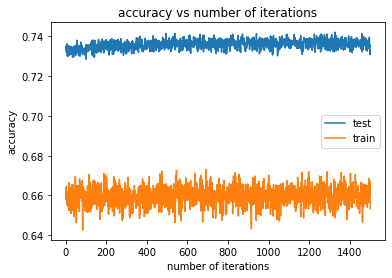

In [25]:
test_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

fig, ax = plt.subplots()
ax.set_xlabel('number of iterations')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs number of iterations')
ax.plot(range(1,len(train_accuracy)+1), train_accuracy,  label="test")
ax.plot(range(1,len(train_accuracy)+1), test_accuracy,  label="train")
ax.legend()
plt.show()
